# Using matplotlib and After Effects for mathematical animations

## Tutorial notebook

Artem Kirsanov, August 2023

Note: this requires `matplotlib <= 3.6` due to some changes in the API 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib
from tqdm.notebook import tqdm
import cmasher
from scipy.interpolate import interp1d
import seaborn as sns

In [ ]:
# Some utility functions
def make_segments(x,y):
    ''' Make segments for LineCollection'''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    return np.concatenate([points[:-1], points[1:]], axis=1)

def setup_time_axes():
    '''
        Setup a black Figure and Axes
    '''
    fig, ax = plt.subplots(1,1,figsize=(20,4),dpi=300)
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.set_xlim(t_start-0.1, t_end+0.1)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(color='white', linewidth=0.4, alpha=0.3, zorder=0)
    return fig, ax

def plot_LineCollection_on_axis(ax,x,y,colors="white", alphas=1, **kwargs):
    '''
        Plot a LineCollection on a specified axis.
        
        ax - Axes object
        x - array of x points
        y - array of y points
        colors - array of colors for each point
        alphas - array of opacity for each point
    '''
    lc = matplotlib.collections.LineCollection(make_segments(x, y),**kwargs)
    lc.set_colors(colors)
    lc.set_alpha(alphas)
    lc.set_capstyle("round")
    ax.add_collection(lc)
    return lc



def animate_line_collections(line_collections, fig, fills=None, only_fills=False,frame_downsampling=1):
    '''
        Creates an animation of multiple LineCollections being drawn
        
        Optionally can animate fills under the lines in sync
    '''
    x_datas = []
    y_datas = []
       
    for lc in line_collections:
        segments = lc.get_segments()
        x_datas.append(np.array([seg[0,0] for seg in segments]))
        y_datas.append(np.array([seg[0,1] for seg in segments]))
    
    def anim_func(playhead_t):
        for k,lc in enumerate(line_collections):
            lc.set_alpha(x_datas[k]<=playhead_t)
           
        if fills is None:
            return line_collections,
        
        mask =  x_datas[0]>=playhead_t
        x_masked=np.ma.masked_where(mask,x_datas[0])
        ax.collections.clear()
        
        for k,fill in enumerate(fills):
            
            y_masked=np.ma.masked_where(mask,y_datas[k])
            fills[k] = ax.fill_between(x_masked,0,y_masked,color=fill.get_facecolor(),alpha=fill.get_alpha())
            
        if not only_fills:
            ax.add_collection(lc)   
        return line_collections,fills
    
    return matplotlib.animation.FuncAnimation(fig, anim_func,frames=tqdm(x_datas[0][::frame_downsampling]),interval=30)

## 0) Generating data

In [ ]:
def get_wave_with_variable_frequency(time, freq_array):
    ''' Returns a array sin(f(t) * t) '''
    dt = np.full_like(time, time[1]-time[0] )  
    phases = (freq_array * 2*np.pi * dt ).cumsum()   
    return np.sin(phases), ((phases + np.pi) % (2 * np.pi) - np.pi)

phase_cmap = sns.color_palette("hls",as_cmap=True) # Periodic colormap to turn phase (angles) into colors

def angle2color(angle):
    return phase_cmap((angle%(2*np.pi))/(2*np.pi))

In [ ]:
N_points = 5000
t_start = 0
t_end = 5



time = np.linspace(t_start,t_end, N_points) # Array of time points

# Generating a random frequency modulation pattern
generator = np.random.default_rng(seed=322)
x_samples = np.linspace(t_start, t_end, 10)
freq_samples = generator.random(x_samples.shape) * 6
interpolation = interp1d(x_samples, freq_samples, kind='quadratic')

freq = interpolation(time) # Array of frequencies (instantaneous rotation velocities)

wave, phase = get_wave_with_variable_frequency(time, freq) # Arrays containing the points of sinusoid and their phases

In [ ]:
FRAME_DOWNSAMPLING = 1  # This is so that all animations have an equal number of frames

## 1) Drawing a phase-colored wave
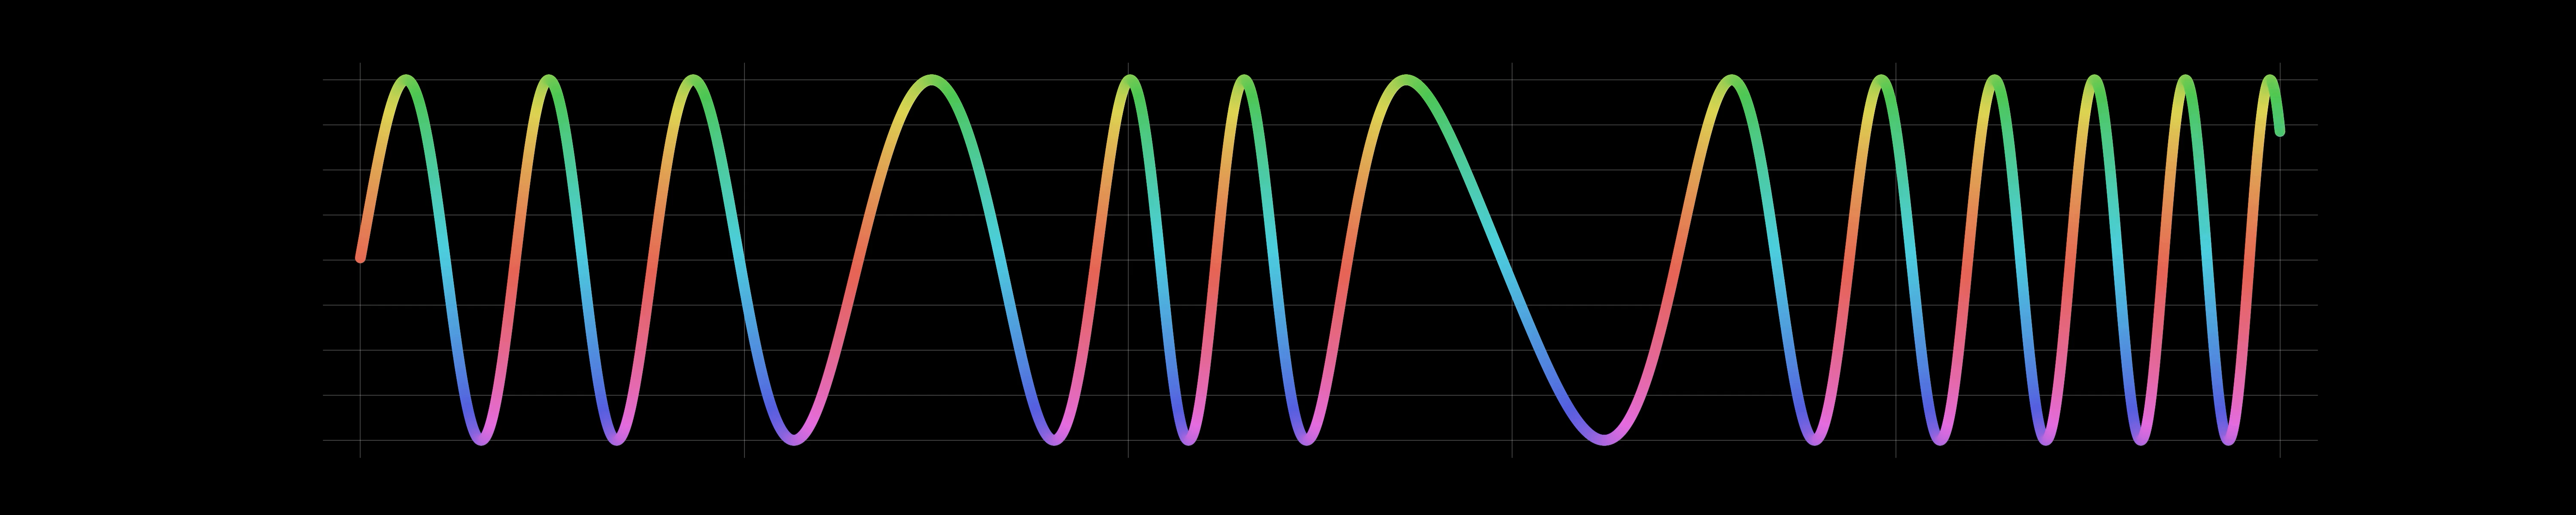

In [ ]:
fig, ax = setup_time_axes()

lc = plot_LineCollection_on_axis(ax, time, wave, angle2color(phase[:-1]), linewidths=6,)

anim = animate_line_collections([lc],fig, frame_downsampling=FRAME_DOWNSAMPLING)
anim.save("renders/1) Drawing a phase-colored wave.mp4")

## 2) Drawing frequency graph
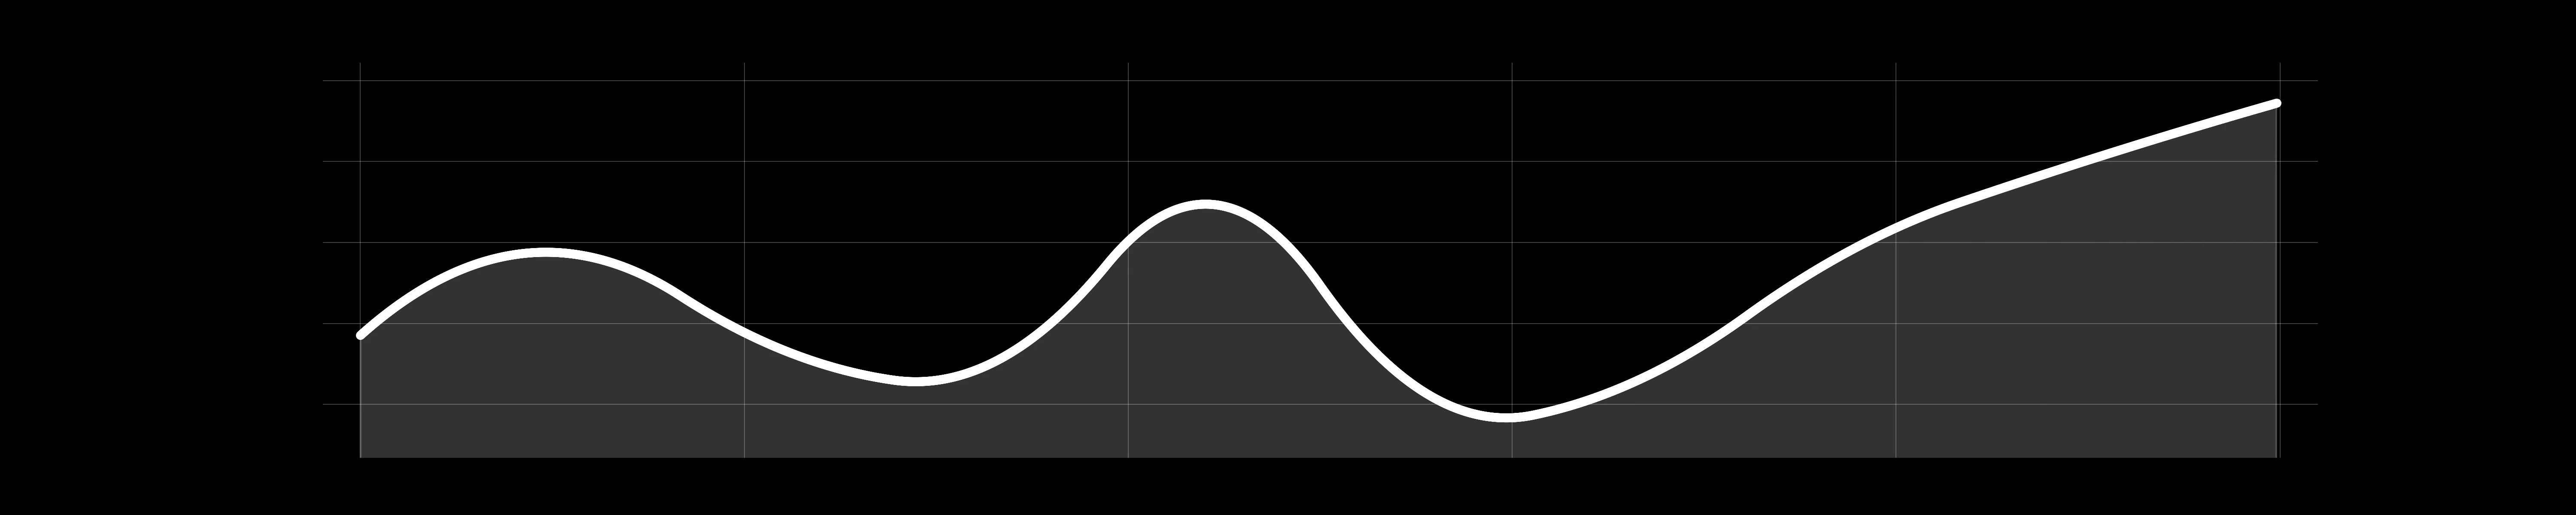

In [ ]:
fig, ax = setup_time_axes()

ax.set_ylim(np.min(freq)-0.5, np.max(freq)+0.5)

lc = plot_LineCollection_on_axis(ax, time, freq, linewidths=5)
fill = ax.fill_between(time,0,freq,color="white",alpha=0.2)

anim = animate_line_collections([lc],fig,fills=[fill],frame_downsampling=FRAME_DOWNSAMPLING)
anim.save("renders/2) Drawing frequency graph.mp4")

## 3) Arrow circling around
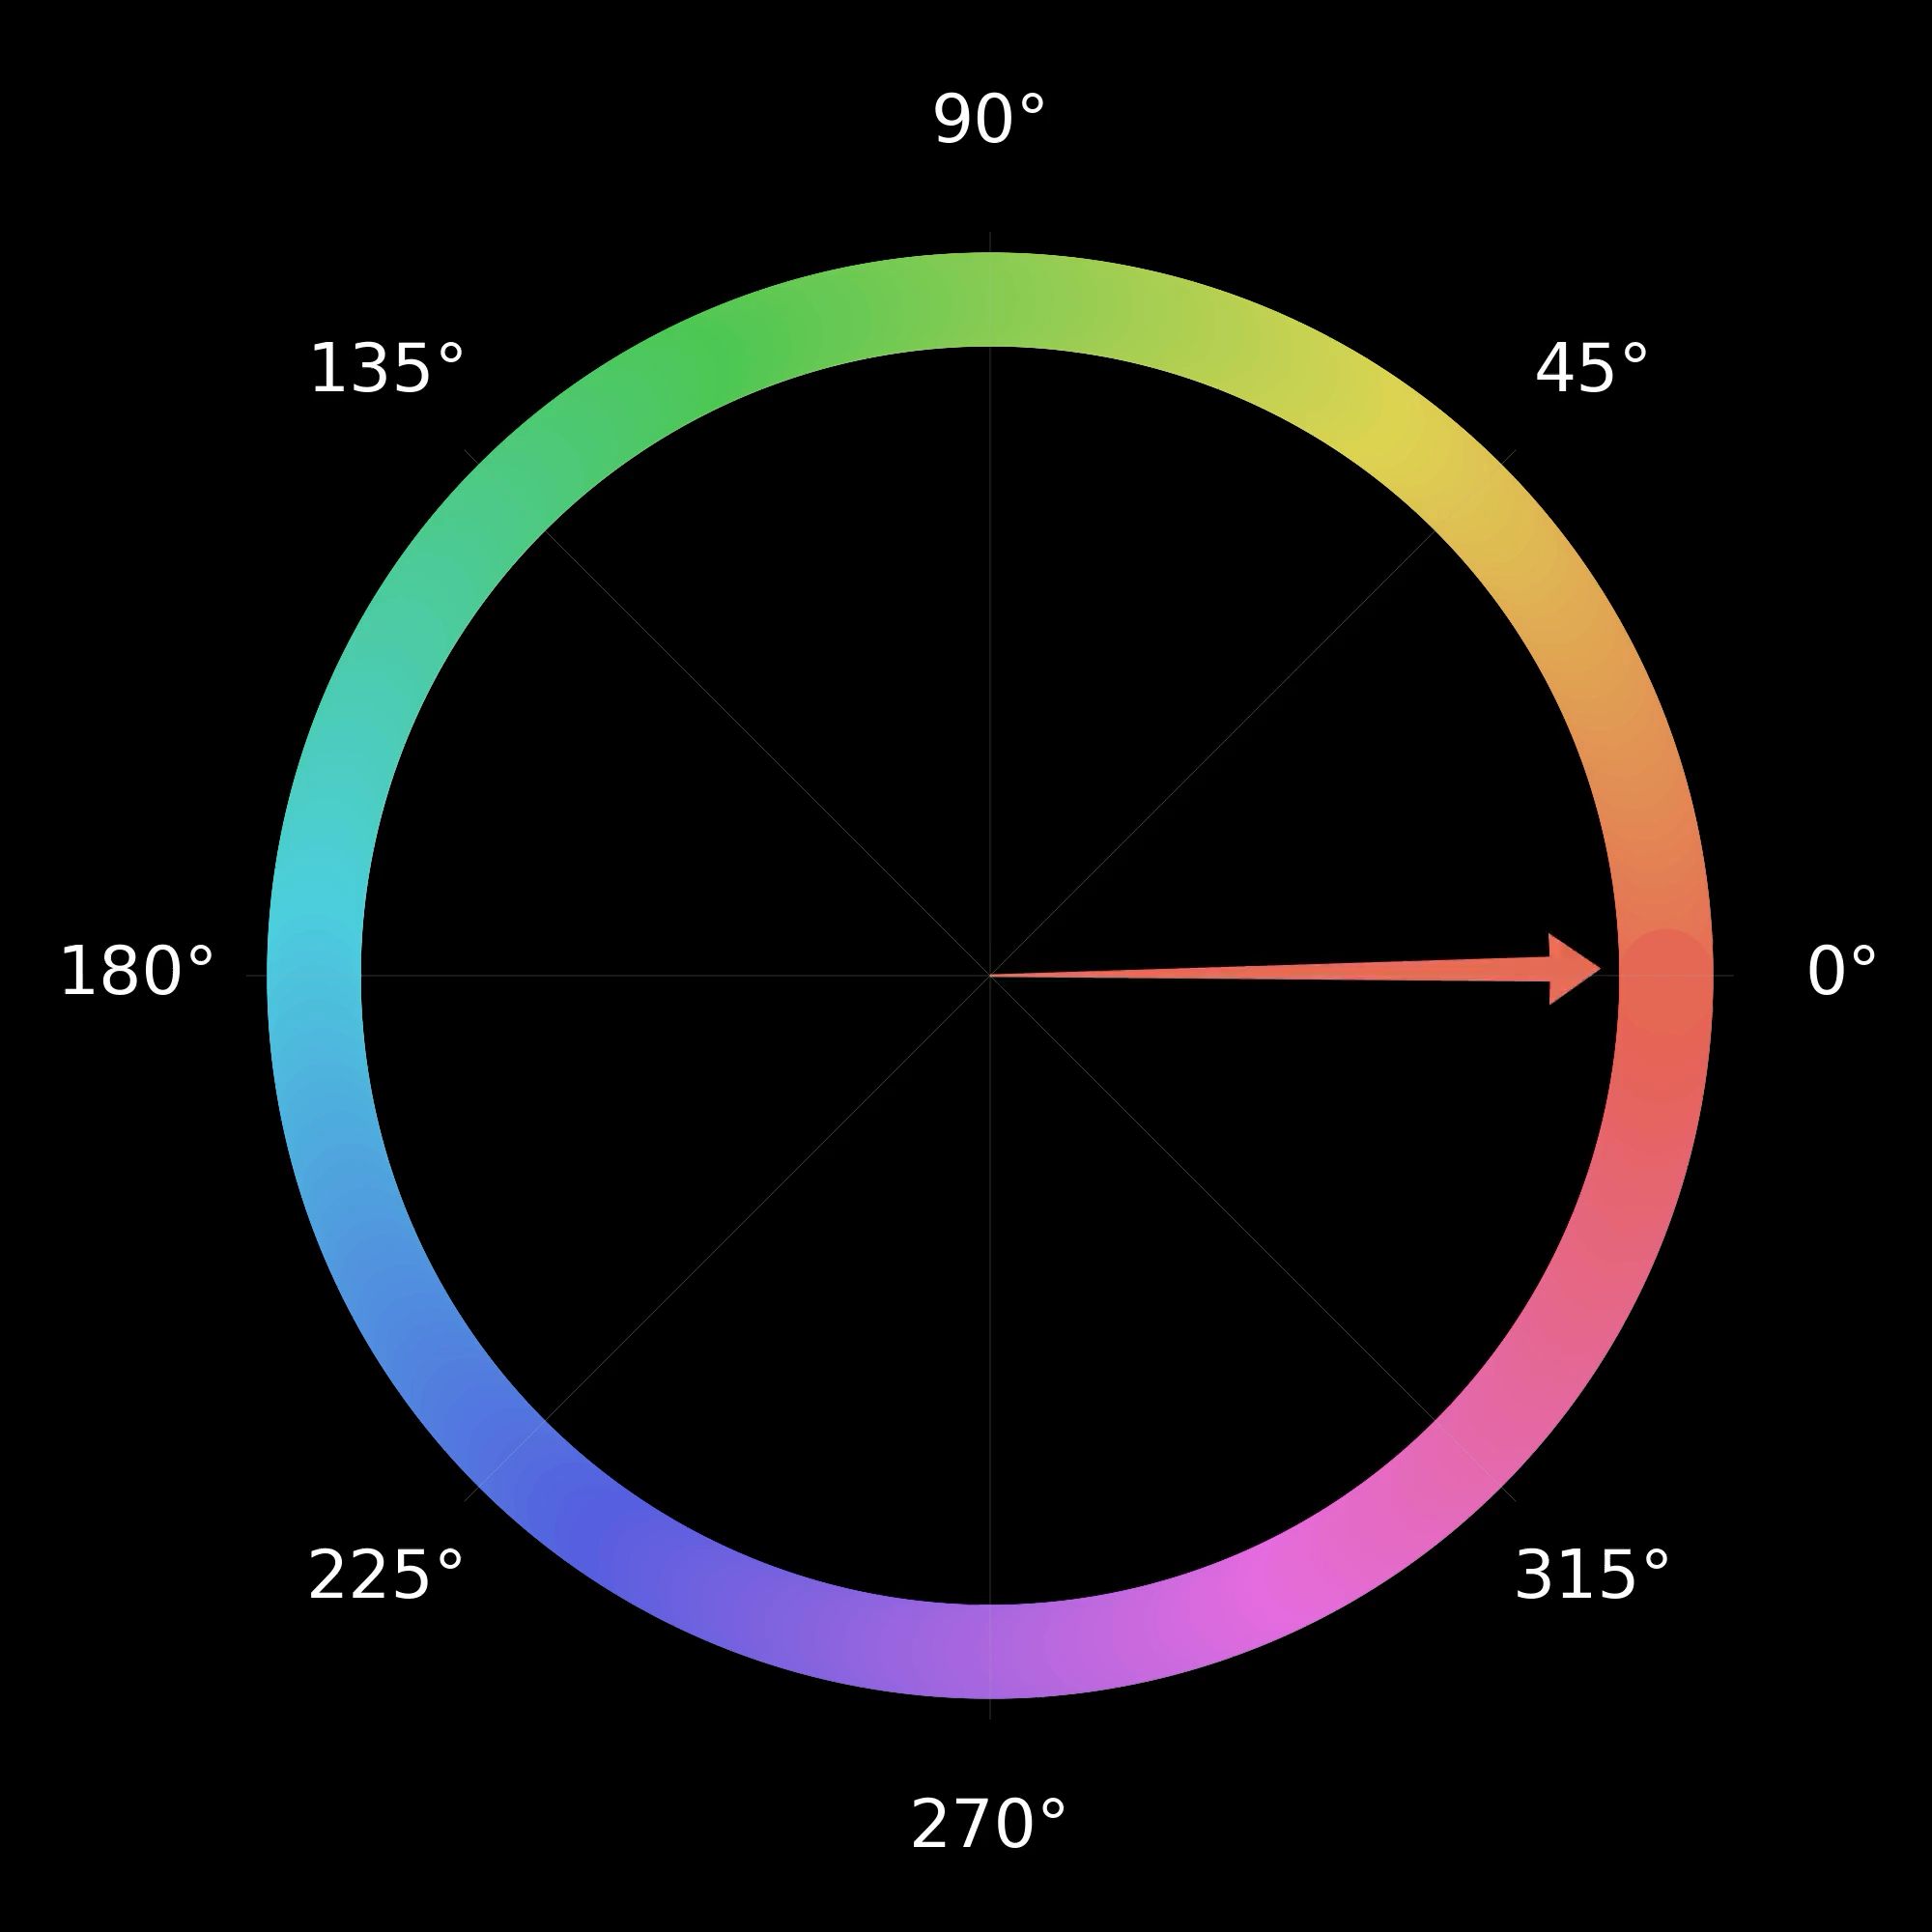

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10),dpi=200,subplot_kw={'projection': 'polar'})

fig.set_facecolor("black")
ax.set_facecolor("black")
ax.set_yticks([])

angle = np.linspace(0, 2*np.pi,1000)
radius = np.ones_like(angle)

lc = matplotlib.collections.LineCollection(make_segments(angle, radius), linewidths=35, zorder=1)
lc.set_capstyle("round")
lc.set_array(angle/(2*np.pi))
lc.set_cmap(phase_cmap)
    
    
ax.set_ylim(0,1.1)
ax.add_collection(lc)
ax.spines['polar'].set_visible(False)
ax.tick_params(labelsize=25, labelcolor="white",pad=30)
ax.xaxis.grid(linewidth=0.1)


def get_polar_arrow(angle, arrow_length=0.9):
    return ax.arrow(angle, 0, 0, arrow_length, length_includes_head=True, width = 0.04,head_length=0.07,color=angle2color(angle))

def animate(angle):
    ax.patches.pop(0)
    return get_polar_arrow(angle),

get_polar_arrow(0)
anim = FuncAnimation(fig,animate, frames=tqdm(np.unwrap(phase)[::FRAME_DOWNSAMPLING]),interval=30)
anim.save("renders/3) Arrow circling around.mp4")

## 4) Animating power modulation

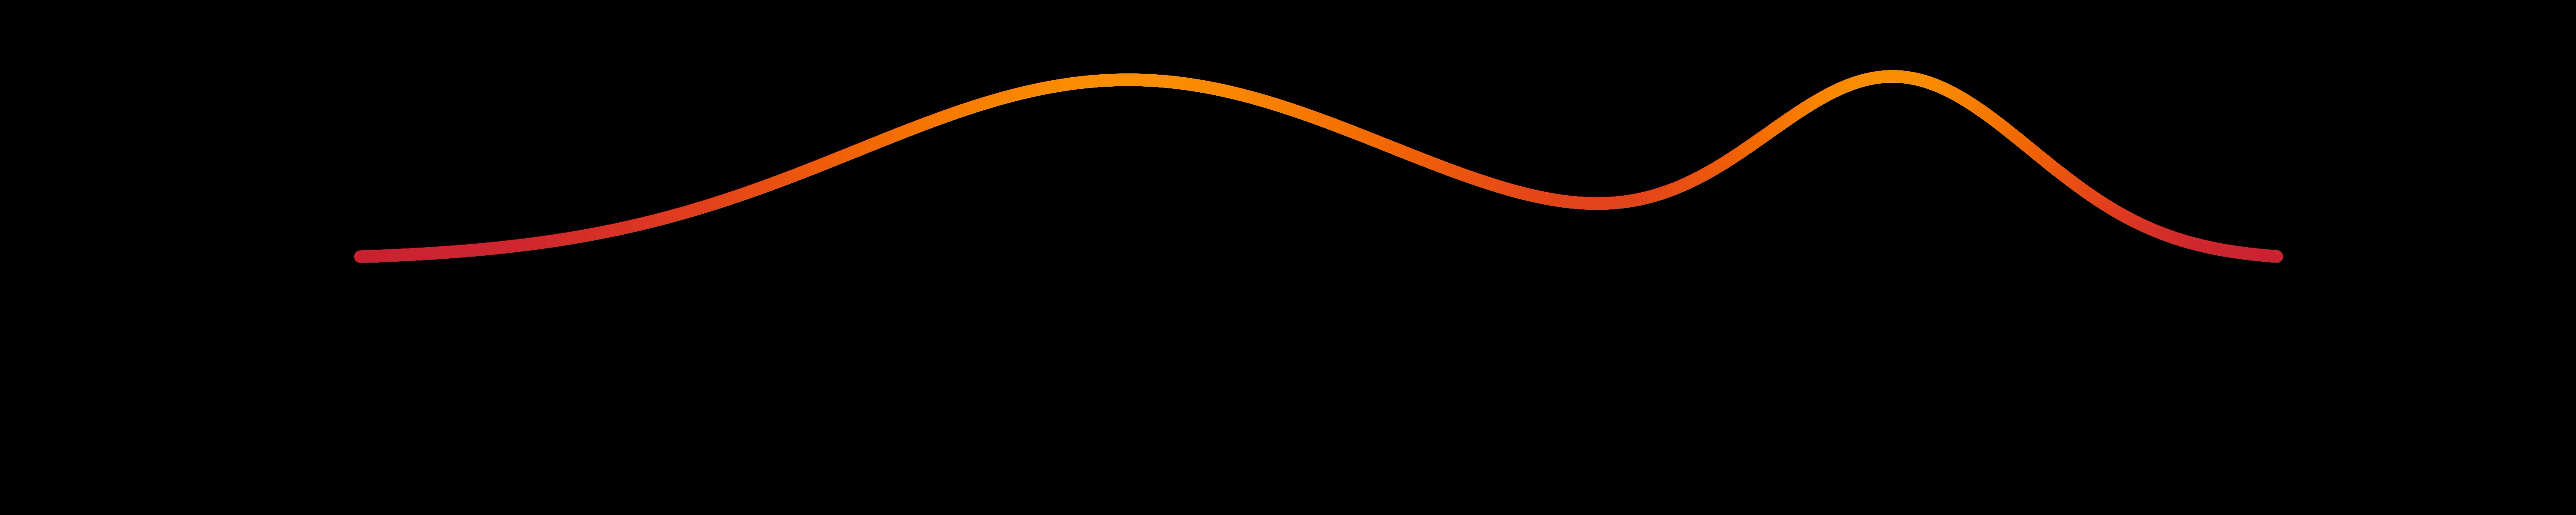
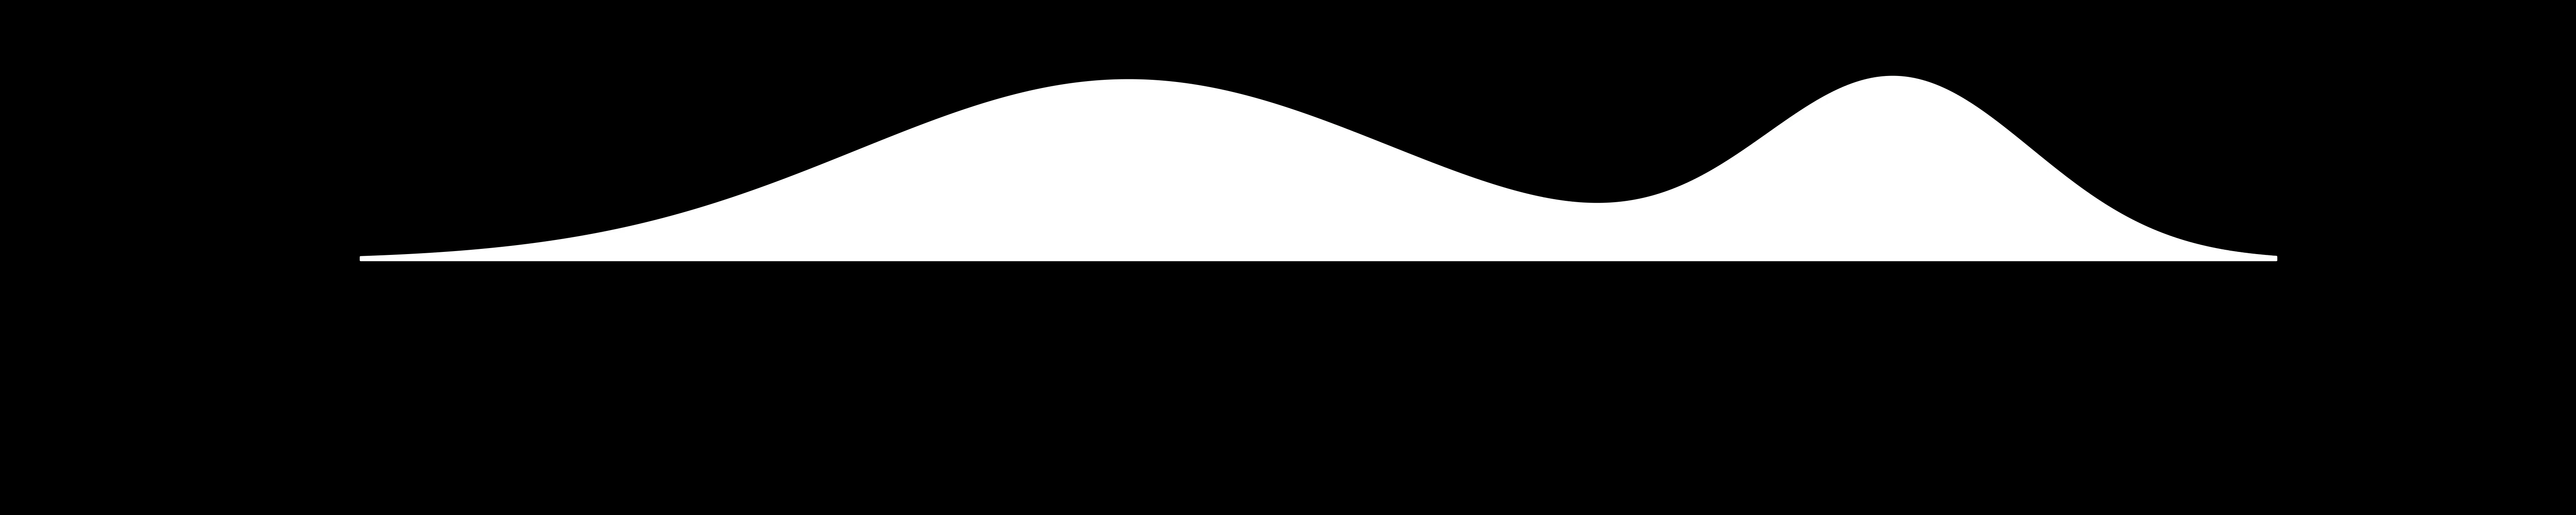

In [ ]:
def gauss(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (sigma)**2)

amplitude_cmap = cmasher.get_sub_cmap(cmasher.ember, 0.5, 0.8)
amplitude =  gauss(time, 2,1) + gauss(time,4,0.5)

In [ ]:
fig, ax = setup_time_axes()
ax.grid(False)
lc = plot_LineCollection_on_axis(ax, time, amplitude, colors = amplitude_cmap(amplitude[:-1]), linewidths=7)

fill = ax.fill_between(time, 0, amplitude, color="white")

anim = animate_line_collections([lc],fig,fills=[],frame_downsampling=FRAME_DOWNSAMPLING)
anim.save("renders/4) Animating power modulation – curve.mp4")

ax.grid(False)
anim = animate_line_collections([lc],fig,[fill],only_fills=True,frame_downsampling=FRAME_DOWNSAMPLING)
anim.save("renders/4) Animating power modulation – fill.mp4")

## 5) Interpolating between waves
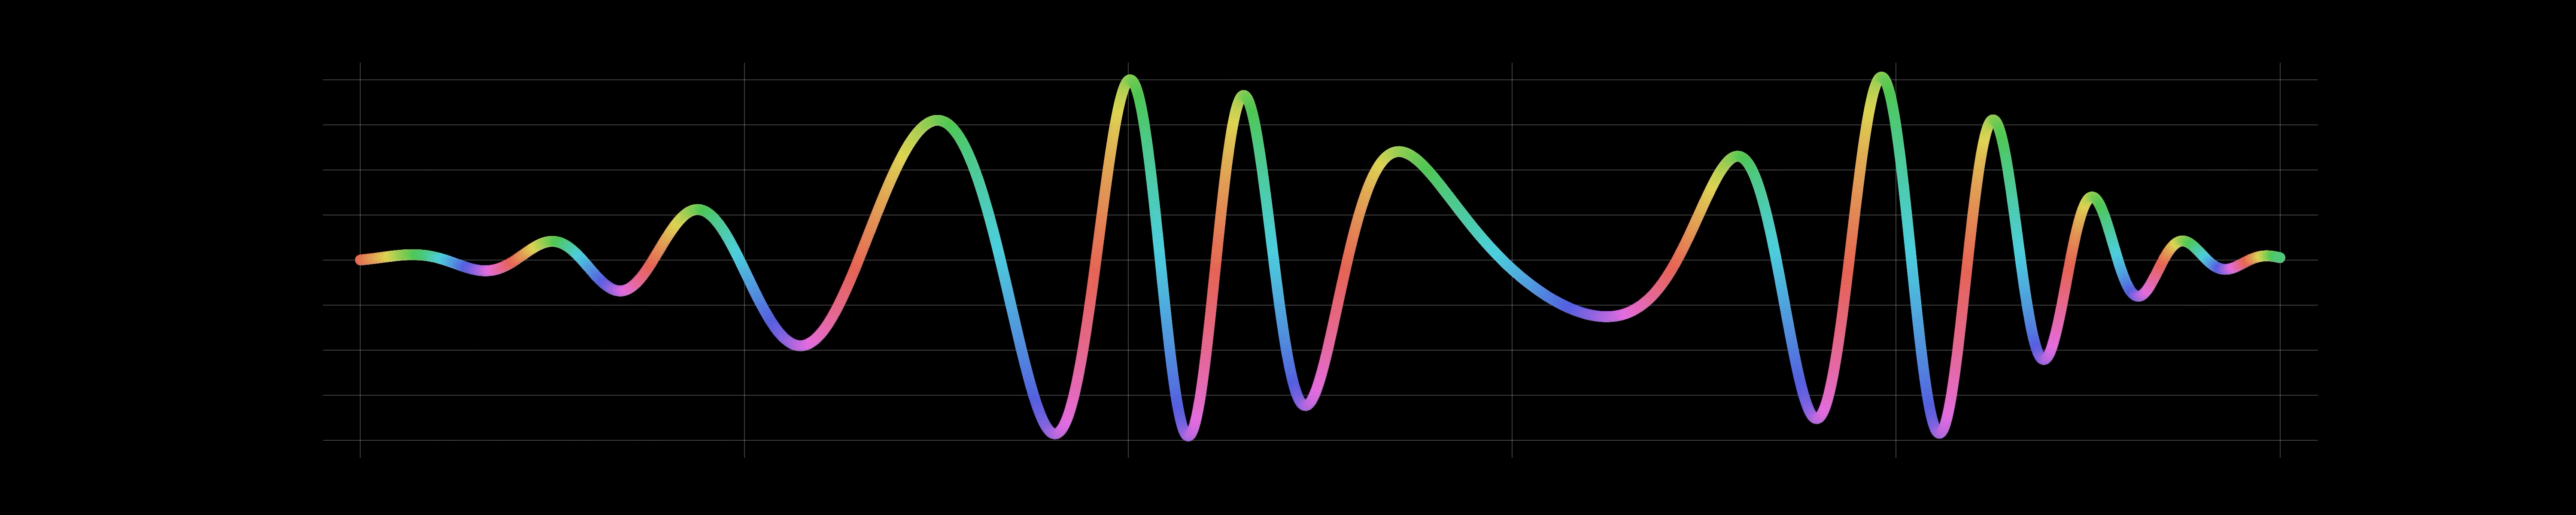

In [ ]:
fig, ax = setup_time_axes()

lc = plot_LineCollection_on_axis(ax, time, wave*amplitude,colors=angle2color(phase[:-1]), linewidths=6)

def animate_interpolation(alpha):
    lc.set_segments(make_segments(time, (1-alpha)*wave + alpha*wave*amplitude))
    return lc

anim = matplotlib.animation.FuncAnimation(fig, animate_interpolation,frames=tqdm(np.linspace(0,1,500)),interval=30)
anim.save("renders/5) Interpolating between waves.mp4")